In [1]:
from visualizations import * 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import argparse
from collections import defaultdict

from scipy import stats
import seaborn as sns

In [2]:
def toshow(x): 
    if x.shape[0] == 1: 
        plt.figure()
        plt.imshow(x[0], cmap = "gray")
        plt.axis("off")
        plt.show()
    elif x.shape[0] == 3: 
        x = np.moveaxis(x, [0, 1, 2],[2, 0, 1])
        plt.figure()
        plt.imshow(x)
        plt.axis("off")
        plt.show()

def bars(deg = 0, sigma = 0.5, x = 0, y = 0, shape = (100, 100), length = 25):
    normal = np.linspace(-10, 10, 100)
    line = stats.norm.pdf(normal, 0, sigma)
    img = np.array([line]*length).transpose()
    img = img/(np.max(img)) * 1
    img = Image.fromarray(img)
    img = img.rotate(deg)
    img = img.transform((shape[1], shape[0]), Image.AFFINE, \
                        (1, 0, int(-x + length/2 - shape[1]/2), 0, 1, y))
    img = np.array(img)
    return img

def generate_bars(degrange, sigrange, xrange, yrange, shape = (28, 28+14)): 
    batches = []
    for deg in degrange:
        batch = []
        for sig in sigrange: 
            for x in xrange: 
                for y in yrange: 
                    img = bars(deg = deg, x = x, y = y, sigma = sig, shape = shape)
                    img = np.stack([img]*3)
                    batch.append(img)
        batch = torch.FloatTensor(np.array(batch))
        batches.append(batch)
    
    return batches

In [3]:
def calculate_activations(net, batches, im, conv_layers = ["conv1_out", "conv2_out", "conv3_out", "conv4_out"]):
    with torch.no_grad():
        attended_activations = defaultdict(lambda: [])
        not_attended_activations = defaultdict(lambda: [])

        noise = 0.0

        for batch in batches:
            attended = defaultdict(lambda: [])
            not_attended = defaultdict(lambda: [])
            
            digit = torch.stack([im]*batch.shape[0])
            x = batch + digit
            noise_matrix = torch.FloatTensor(np.random.random(x.shape) * noise)
            n_mask = x <= 0.1
            noise_matrix = noise_matrix * n_mask
            x = x + noise_matrix

            bar = x * (1-strength) + strength * batch
            digit = x * (1-strength) + strength * digit

            x = x.to(device)
            bar = bar.to(device)
            digit = digit.to(device)

            net.initHidden(device, x.shape[0])
            out_mask = {}
            out_mask["conv1_in"] = torch.zeros_like(net.hidden["conv1_in"])
            out_mask["conv2_in"] = torch.zeros_like(net.hidden["conv2_in"])
            out_mask["conv3_in"] = torch.zeros_like(net.hidden["conv3_in"])
            out_mask["conv4_in"] = torch.zeros_like(net.hidden["conv4_in"])

            findselectmask = torch.zeros((x.shape[0], 2)).type(torch.bool)

            for _ in range(2):
                net.initHidden(device, x.shape[0])
                
                #run T-1 iterations
                for _ in range(4): 
                    out = net(x, out_mask = out_mask)
                
                #our new gating mask
                new_out_mask = {}
                new_out_mask["conv1_in"] = ((out_mask["conv1_in"] + (net.hidden["conv1_in"] < 0.5)) > 0.5).type(torch.int)
                new_out_mask["conv2_in"] = ((out_mask["conv2_in"] + (net.hidden["conv2_in"] < 0.5)) > 0.5).type(torch.int)
                new_out_mask["conv3_in"] = ((out_mask["conv3_in"] + (net.hidden["conv3_in"] < 0.5)) > 0.5).type(torch.int)
                new_out_mask["conv4_in"] = ((out_mask["conv4_in"] + (net.hidden["conv4_in"] < 0.5)) > 0.5).type(torch.int)
                
                #run our final iteration
                out = net(x, out_mask = out_mask)

                data = [bar, digit]
                
                masked = net.latent["in"]
                findselect = [torch.sum(torch.nn.MSELoss(reduction='none')(masked, x).detach(), dim= [1, 2, 3]) for x in data]
                findselect = torch.stack(findselect).T
                findselect[findselectmask] = 1e10

                select = torch.argmin(findselect, axis = 1).detach().cpu()
                findselectmask[np.arange(len(findselectmask)), select] = True

                attended_index = select == 0
                not_attended_index = select == 1

                for layer in conv_layers: 
                    conv_out = net.latent[layer].detach()
                    attended[layer].append(conv_out[attended_index])
                    not_attended[layer].append(conv_out[not_attended_index])

                #set the new gating mask
                out_mask = new_out_mask

            for layer in conv_layers: 
                att = torch.cat(attended[layer], 0)
                not_att = torch.cat(not_attended[layer], 0)

                max_att = torch.max(att, 0).values.detach().cpu().numpy()
                max_not_att = torch.max(not_att, 0).values.detach().cpu().numpy()

                attended_activations[layer].append(max_att)
                not_attended_activations[layer].append(max_not_att)


        return attended_activations, not_attended_activations

In [4]:
def plot_curves(attended_activations, not_attended_activations, degrange):
    sns.set_context("talk")
    for layer in attended_activations.keys(): 
        act = np.stack(attended_activations[layer], 3)
        nonact = np.stack(not_attended_activations[layer], 3)
        
        shape = attended_activations[layer][0][0].shape
        r = int(shape[0]/2)
        c = int(shape[0]/4)

        for i in range(act.shape[0]): 
            plt.figure()
            plt.plot(degrange, act[i][r][c], color = (14/255, 77/255, 179/255, 1))
            plt.plot(degrange, nonact[i][r][c], color = (212/255, 78/255, 78/255, 1))
            plt.xlabel("Degrees")
            plt.ylabel("Activation")

            maxval = max(np.max(nonact[i][r][c]), np.max(act[i][r][c]))
            plt.ylim([-0.1*maxval, 1.1*maxval])

            my_folder = "tuning_curves/coco_%s"%(layer)

            if not os.path.exists(my_folder):
                os.makedirs(my_folder)

            plt.savefig("%s/%s.png"%(my_folder, i), format = "png")

In [5]:
degrange = np.linspace(0, 180, 11)
sigrange = np.linspace(0.5, 1.5, 3)
xrange = np.linspace(-40, -25, 8)
yrange = np.linspace(-40, 40, 11)
batches = generate_bars(degrange, sigrange, xrange, yrange, shape = (100, 100))

In [10]:
modelpath = "../saved/models/paper_coco_model.pt" #path to the saved model
modeltype = "coco" #type of model: 'mnist' or 'coco'
cocoroot = '../../../../data/jordanlei/coco/images/val2017' #path to the coco val dataset
annpath = '../../../../data/jordanlei/coco/annotations/instances_val2017.json' #path to the coco val annotations
metadatapath = '../data/metadata/cocometadata_test.p' #path to metadata file (will create one if none exists)

n = 2 #number of objects
strength = 0.5 #strength of attention
net, runner, _ = load_model_and_data(modelpath, n = n, strength = strength, modeltype = modeltype,\
                                               cocoroot = cocoroot, annpath = annpath, metadatapath = metadatapath)
_, _, test_loader = load_model_and_data(modelpath, n = n, strength = 1.0, modeltype = modeltype,\
                                               cocoroot = cocoroot, annpath = annpath, metadatapath = metadatapath)

COCO Object-Based Attention Model v3
loading annotations into memory...
Done (t=0.83s)
creating index...
index created!
COCO Object-Based Attention Model v3
loading annotations into memory...
Done (t=1.02s)
creating index...
index created!


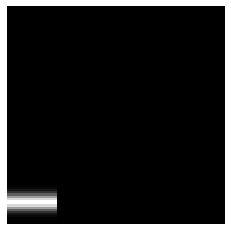

In [7]:
toshow(batches[0][0].numpy())

In [11]:
x, data, _ = test_loader.dataset[5]
im = torch.FloatTensor()
im =  data[1]

attended_activations, not_attended_activations = calculate_activations(net, batches, im)

In [12]:
attended_activations["conv1_out"][0].shape

(30, 97, 97)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


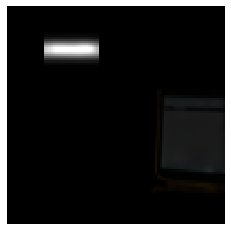

In [68]:
toshow(net.latent["in"][0].detach().cpu().numpy())

/home/jordanlei/.conda/envs/jordan_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':
/home/jordanlei/.conda/envs/jordan_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.


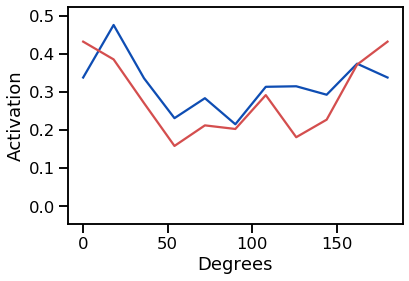

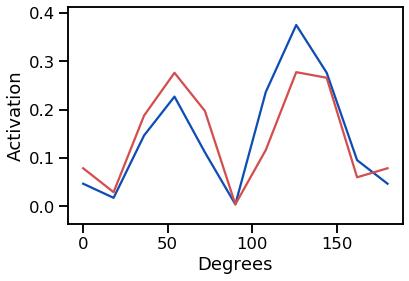

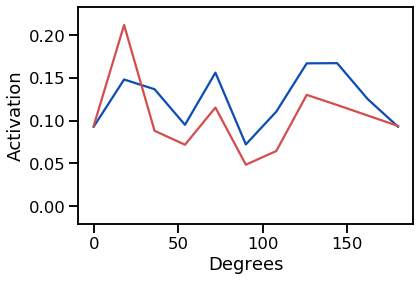

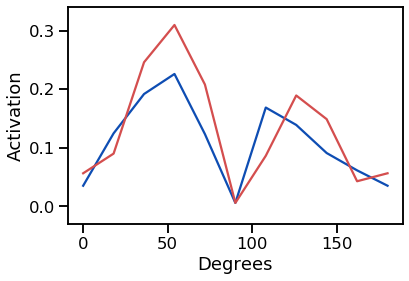

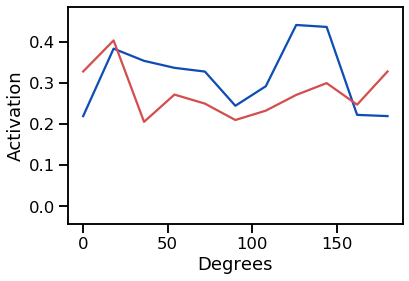

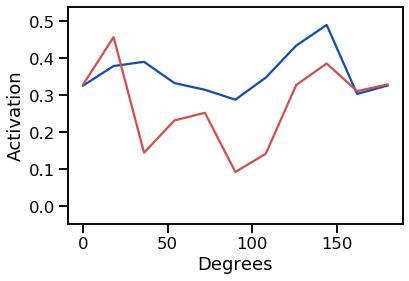

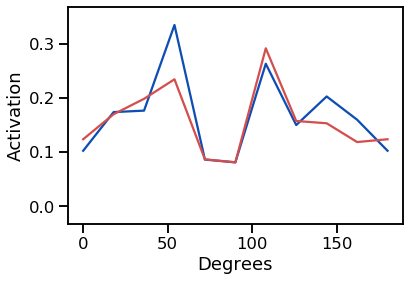

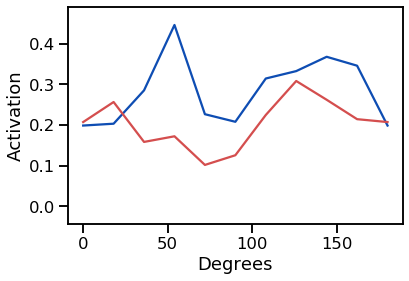

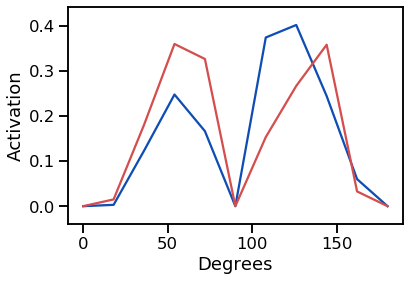

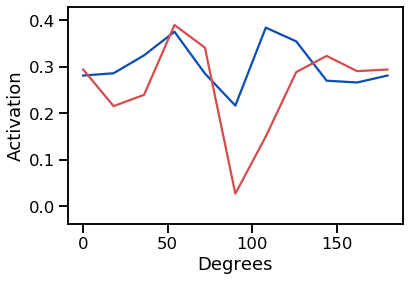

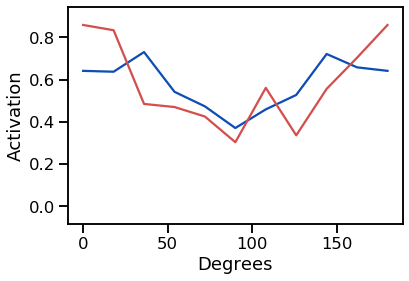

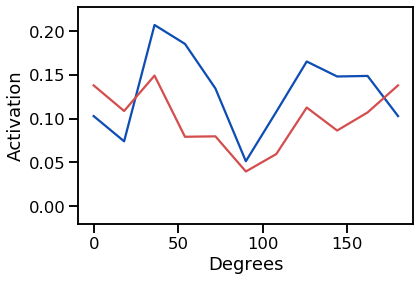

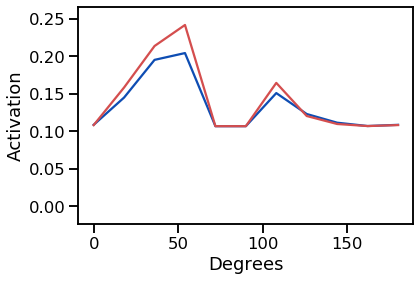

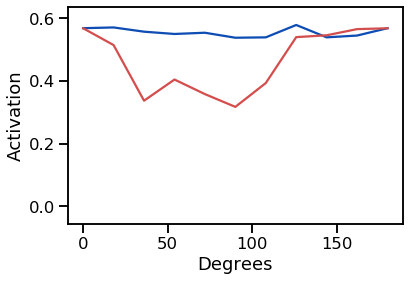

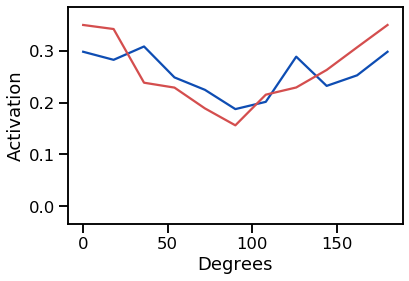

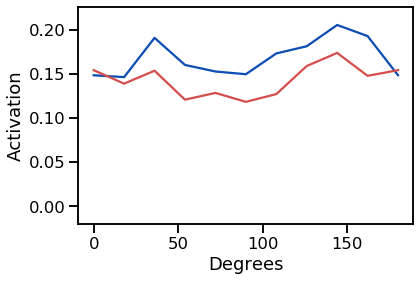

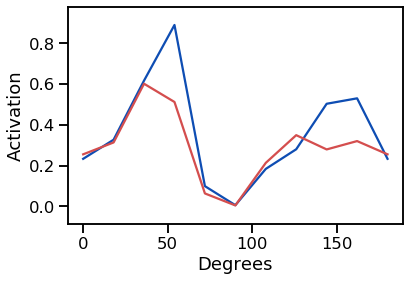

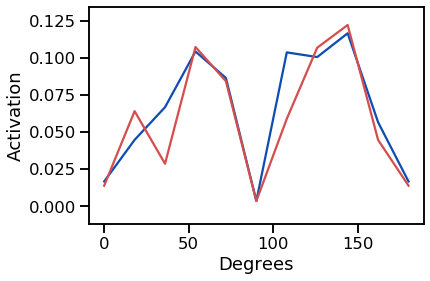

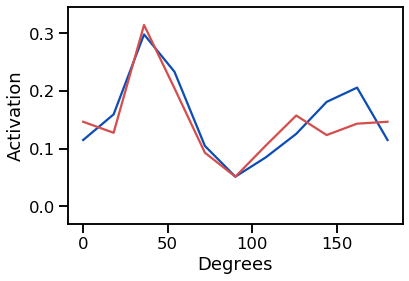

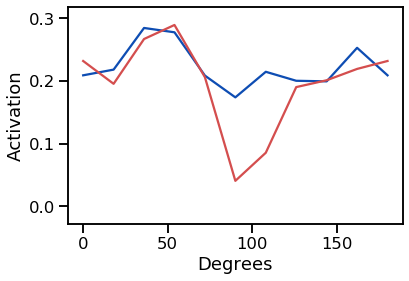

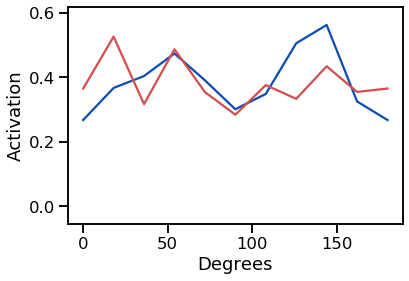

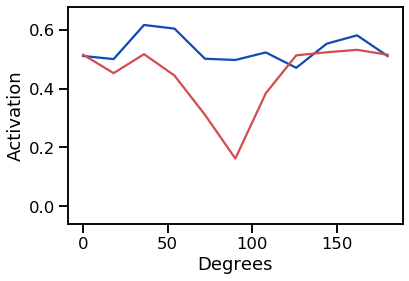

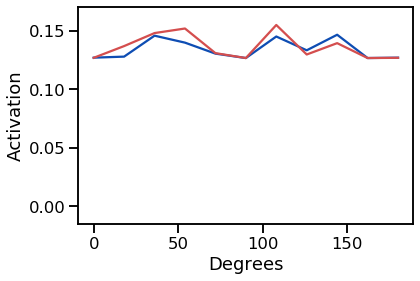

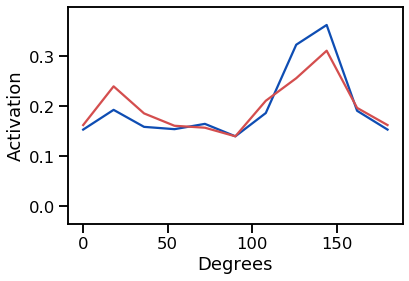

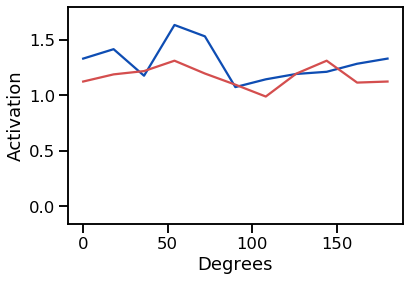

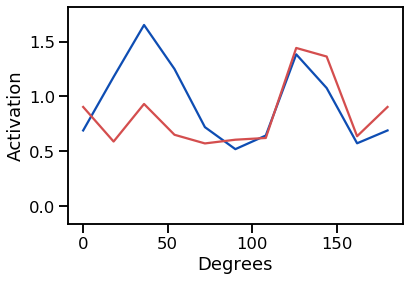

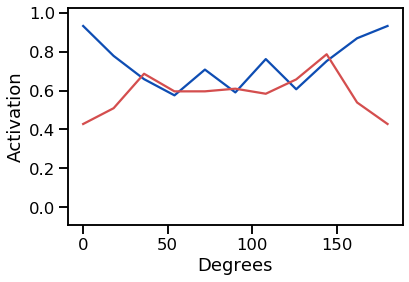

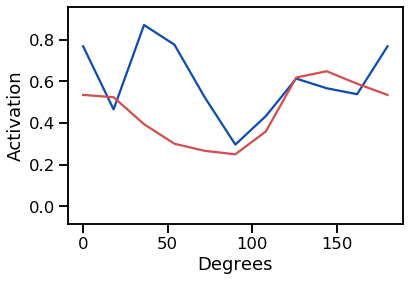

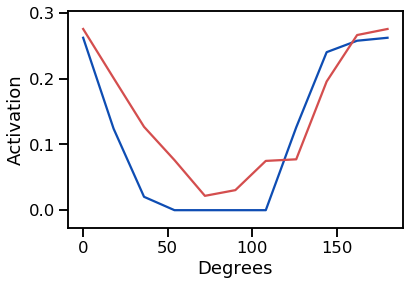

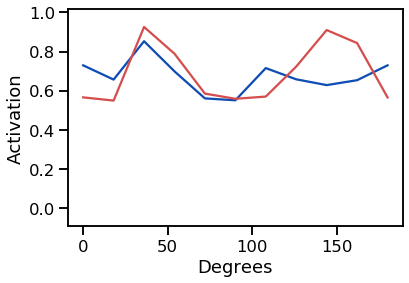

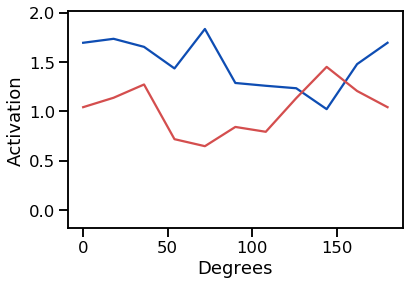

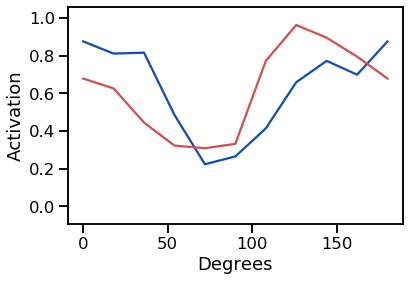

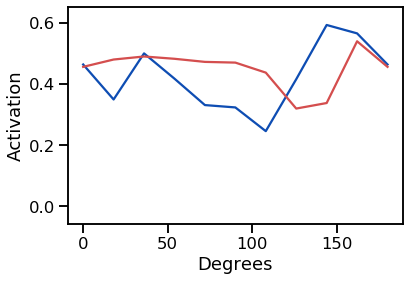

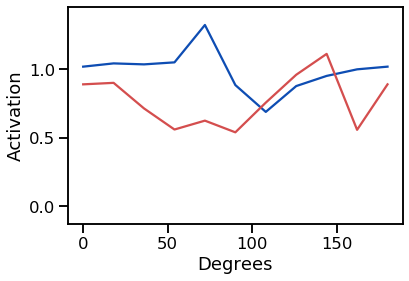

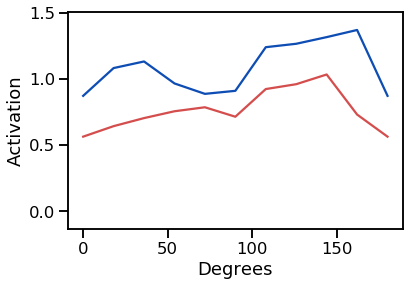

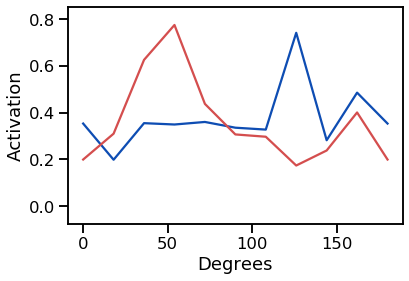

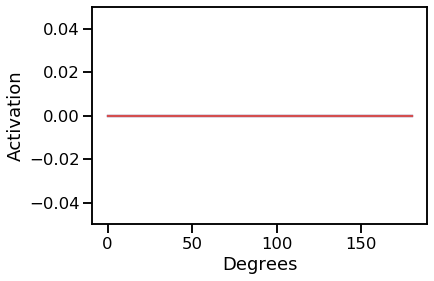

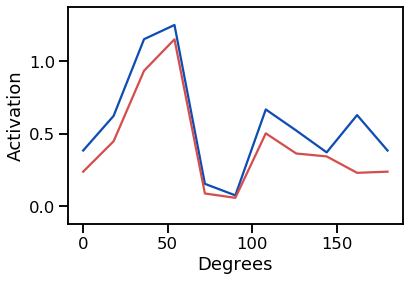

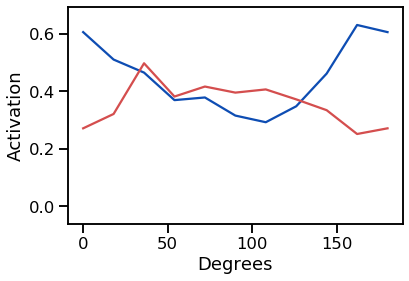

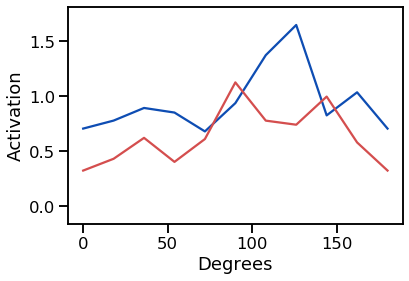

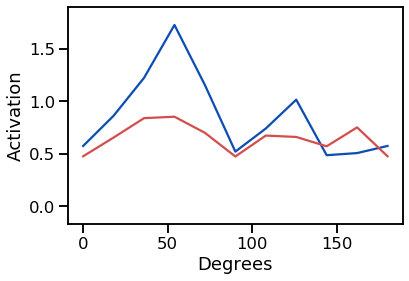

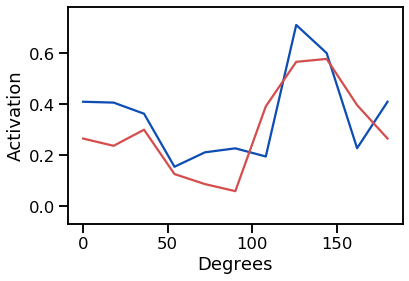

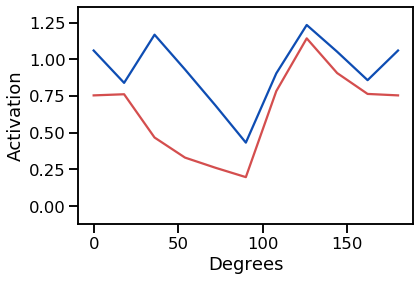

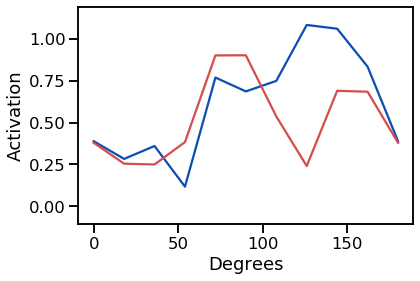

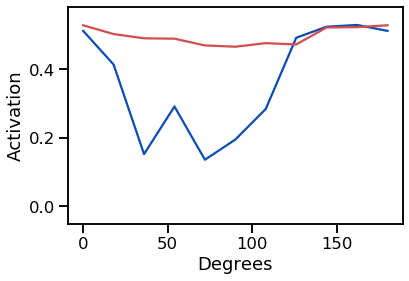

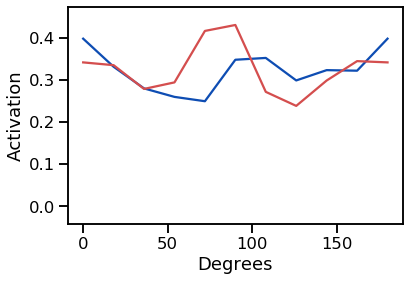

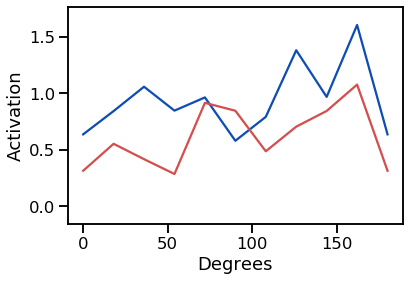

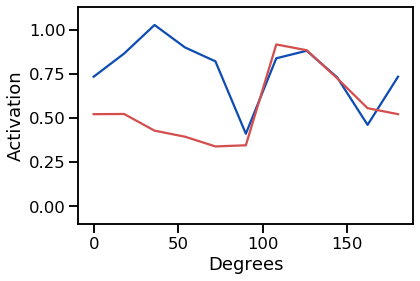

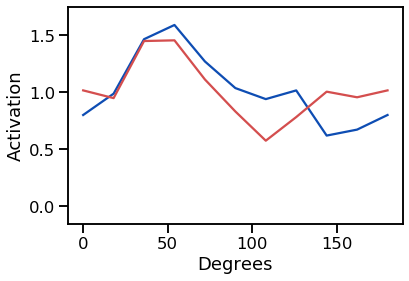

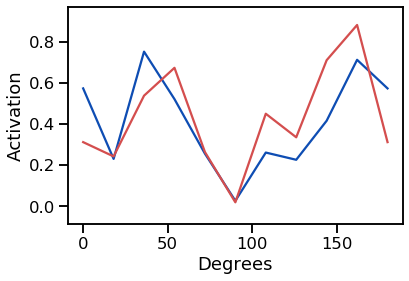

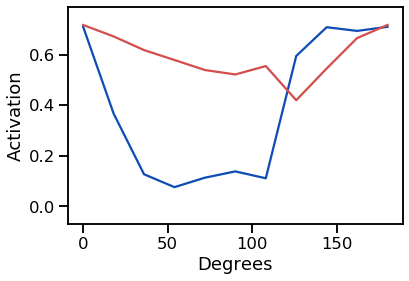

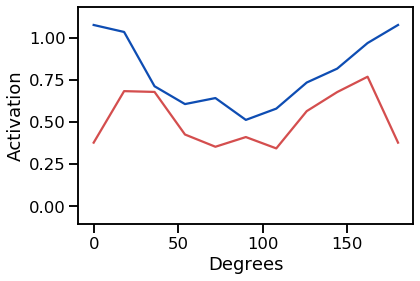

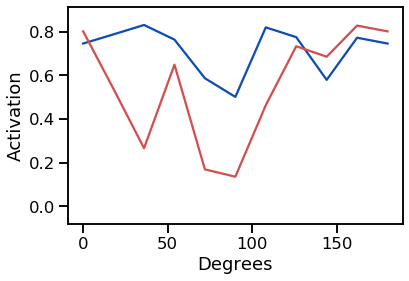

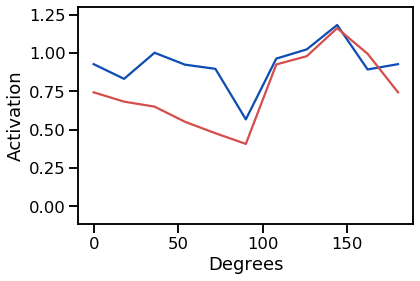

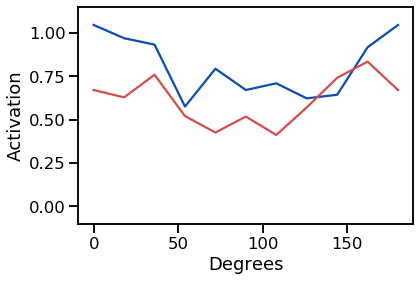

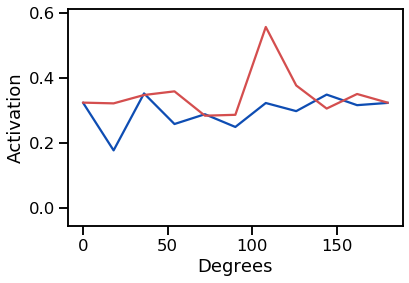

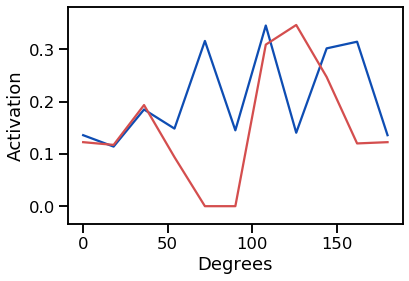

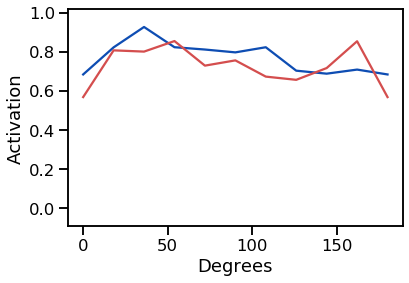

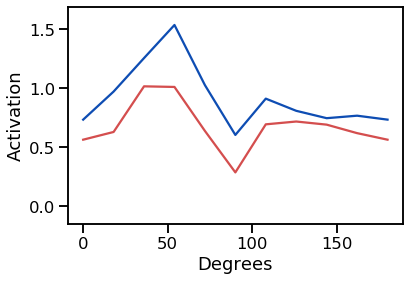

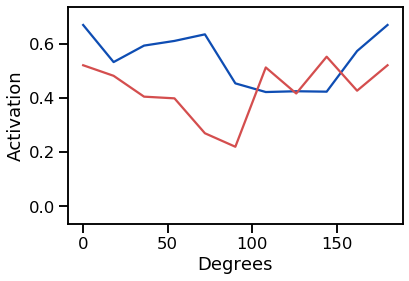

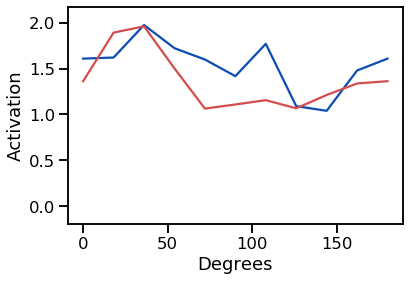

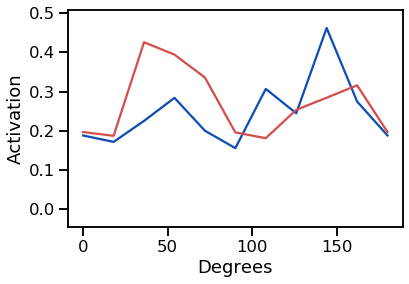

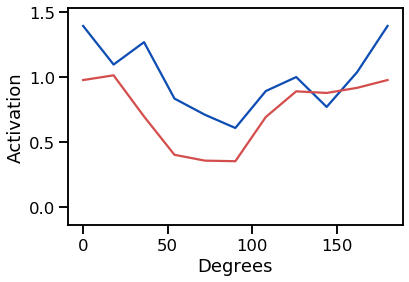

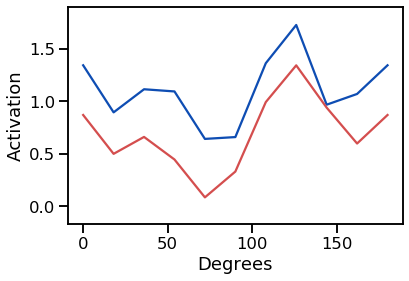

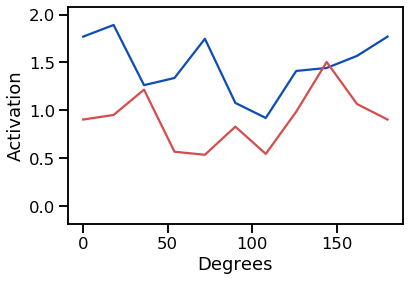

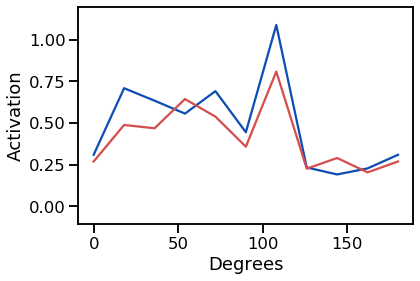

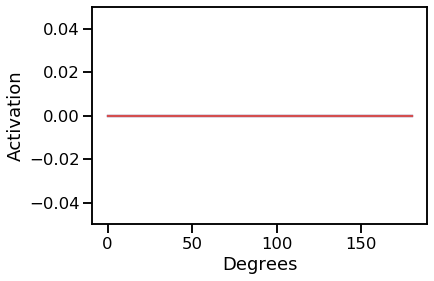

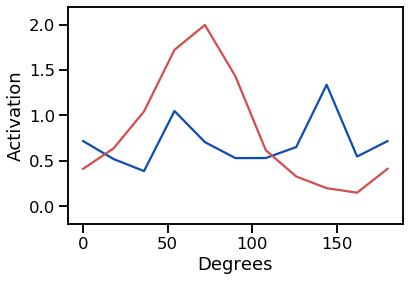

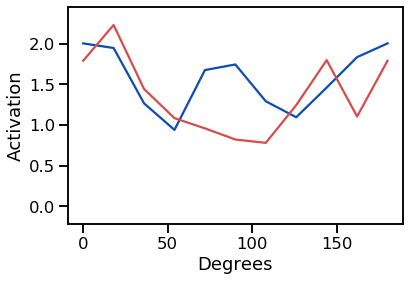

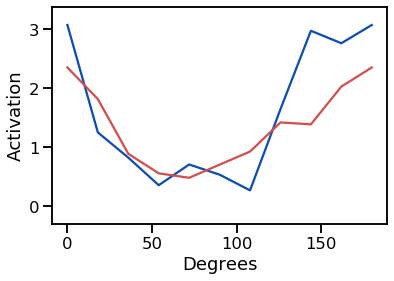

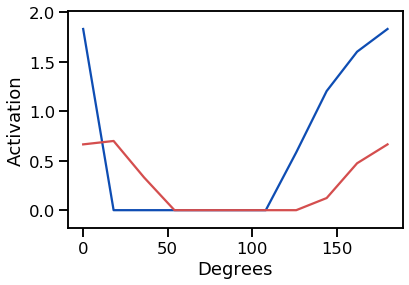

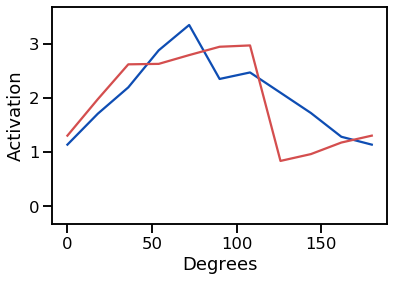

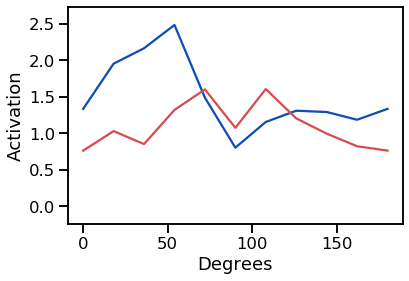

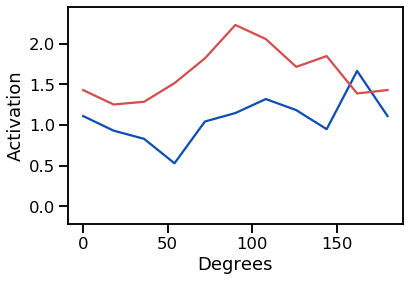

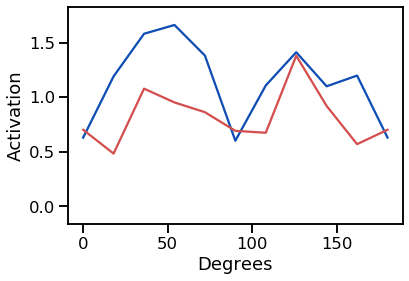

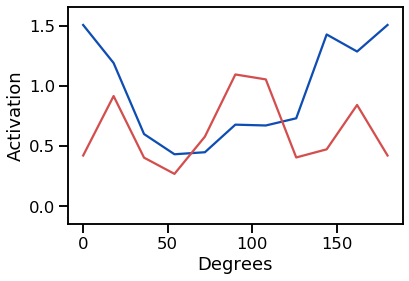

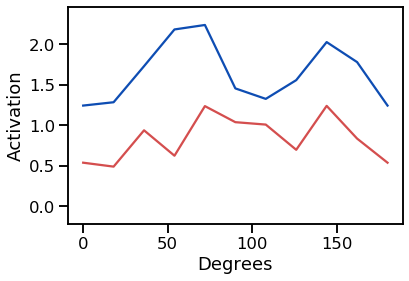

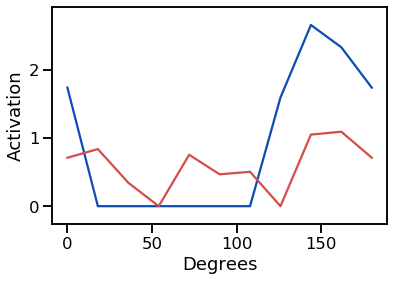

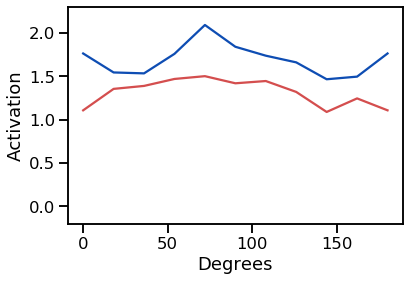

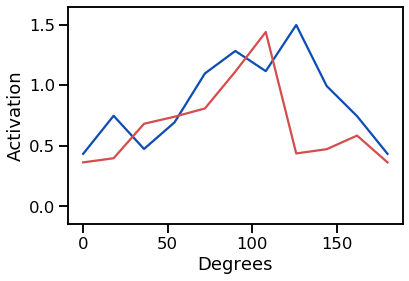

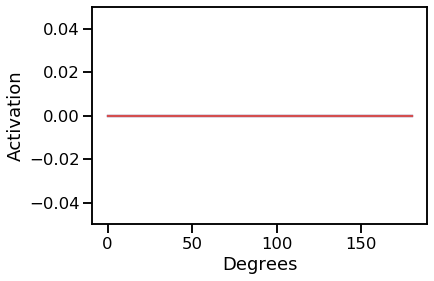

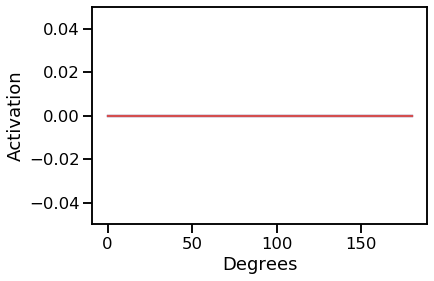

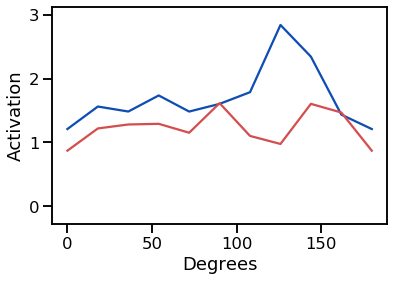

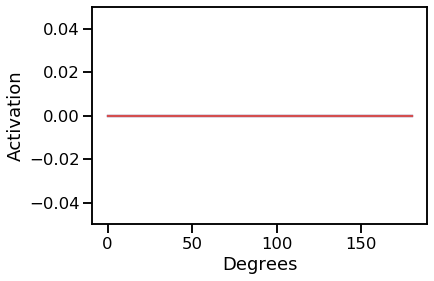

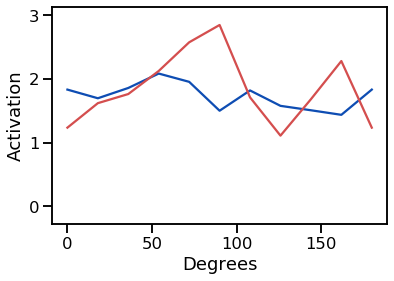

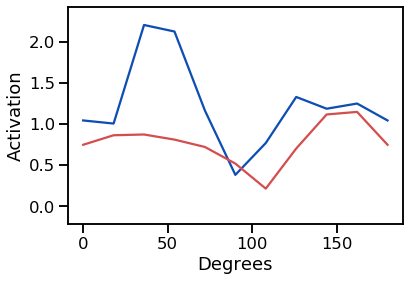

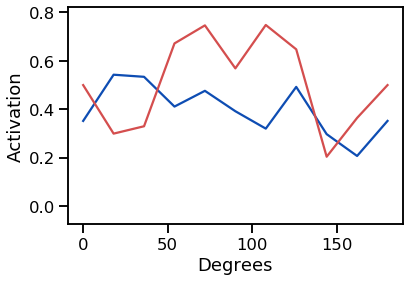

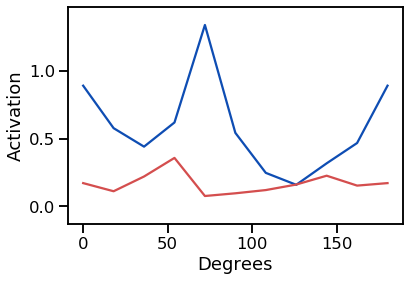

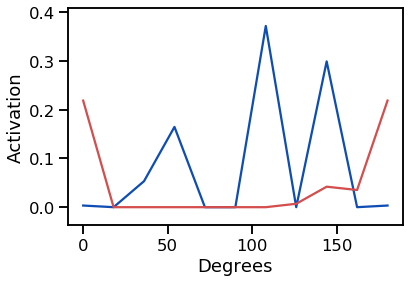

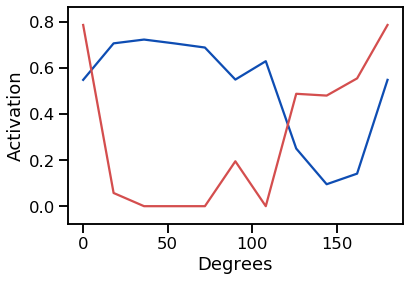

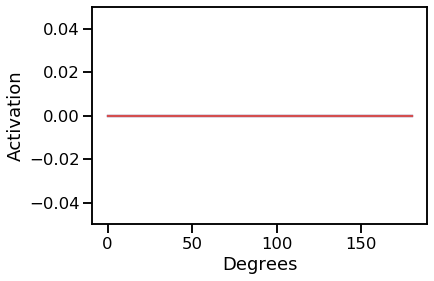

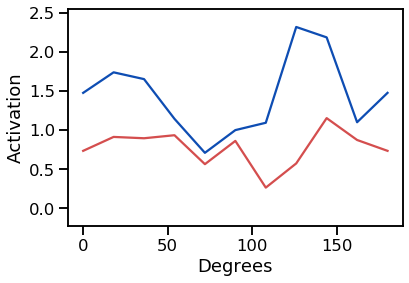

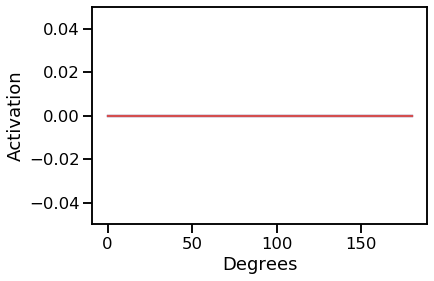

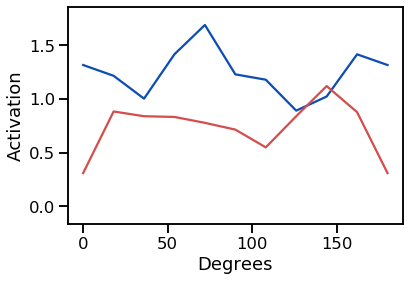

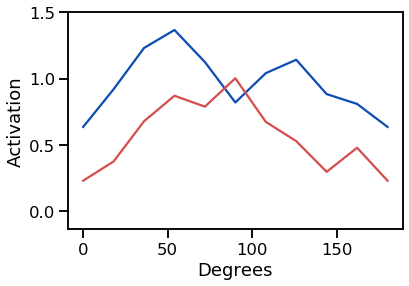

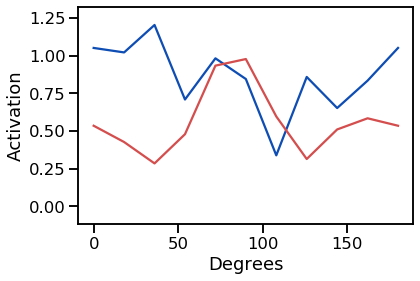

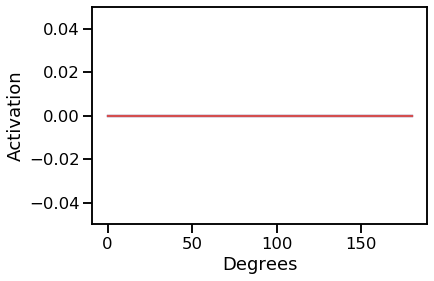

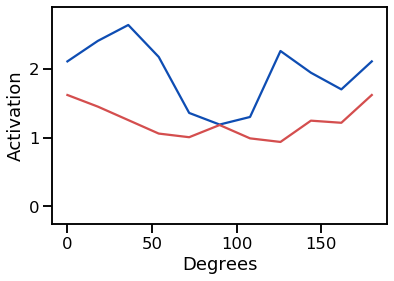

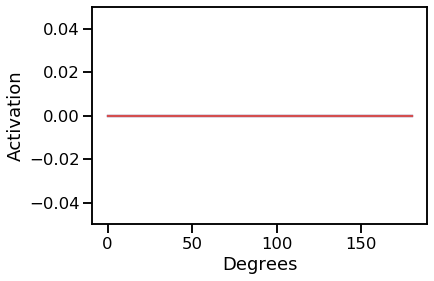

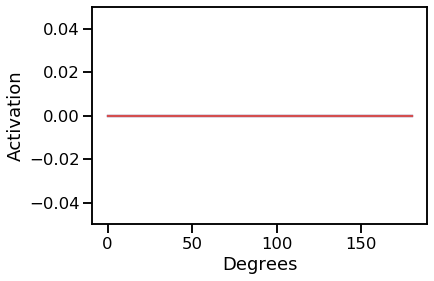

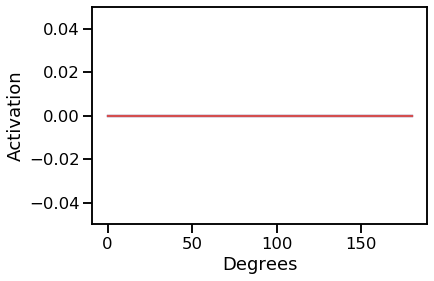

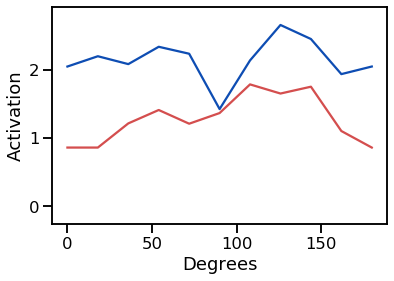

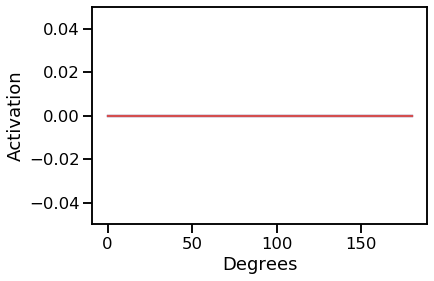

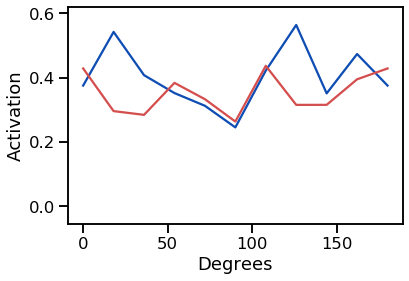

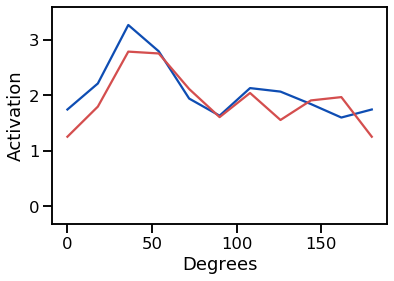

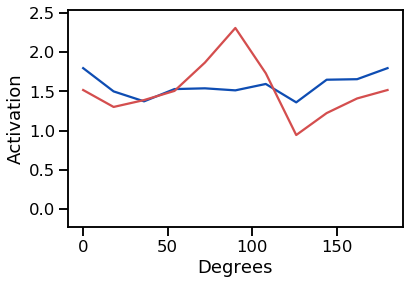

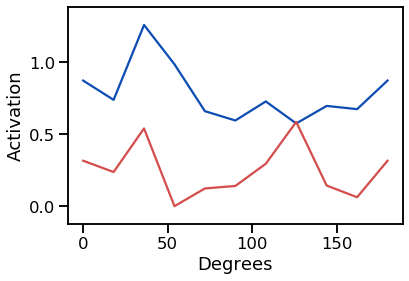

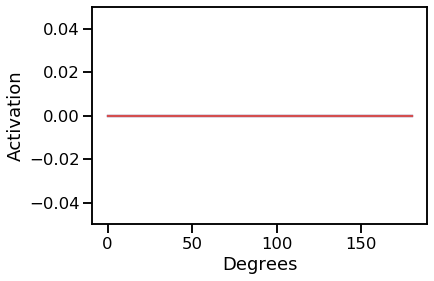

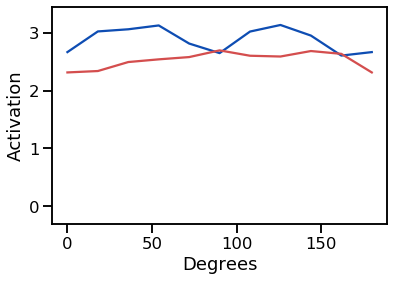

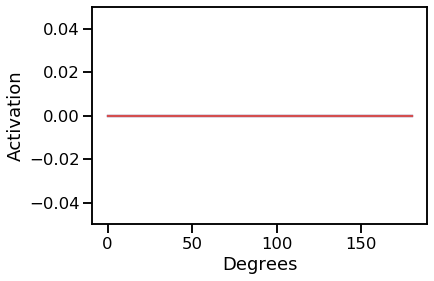

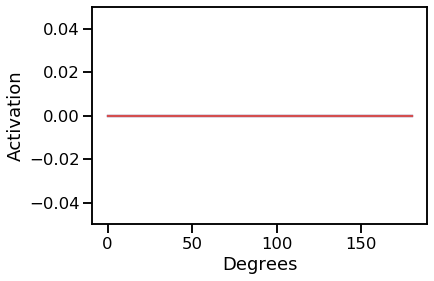

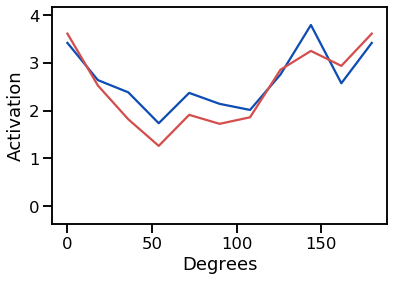

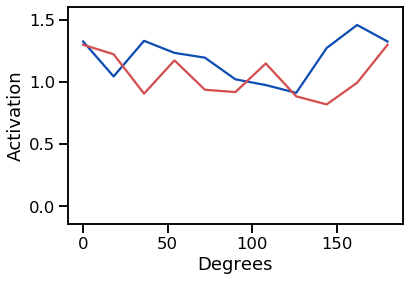

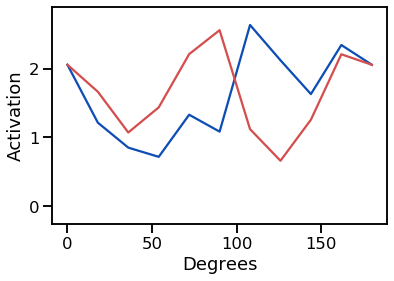

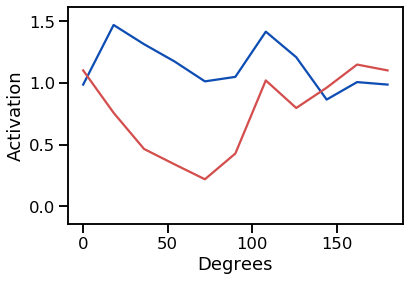

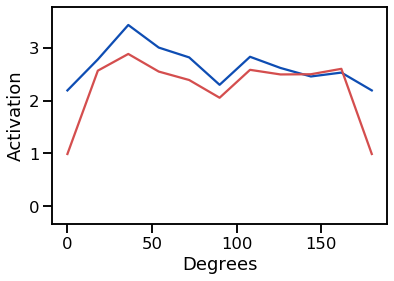

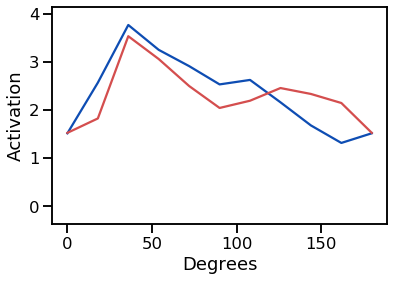

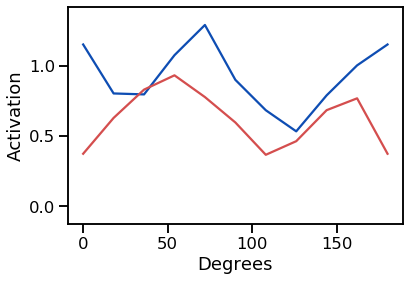

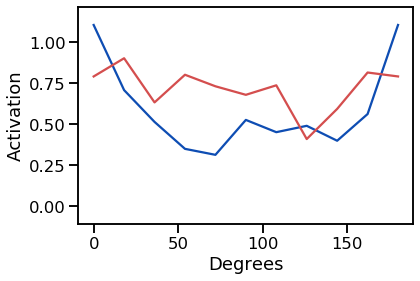

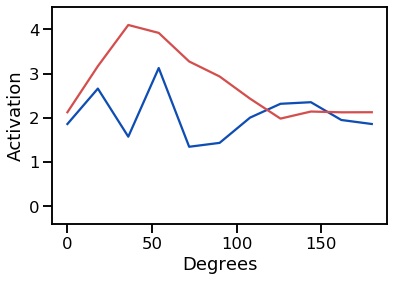

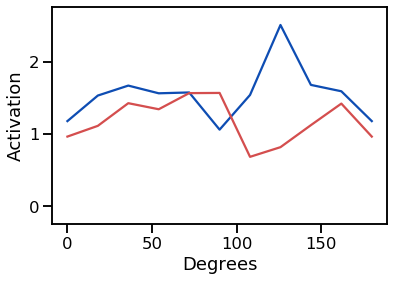

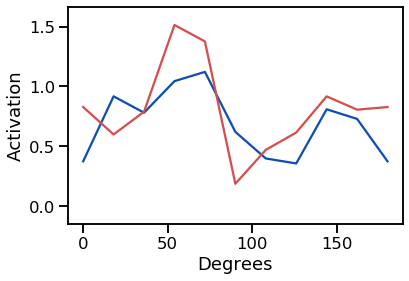

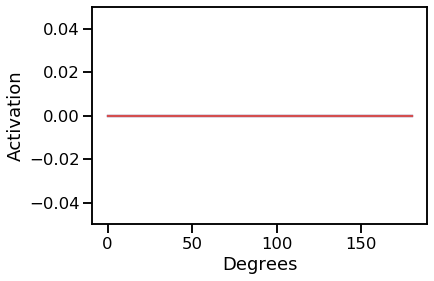

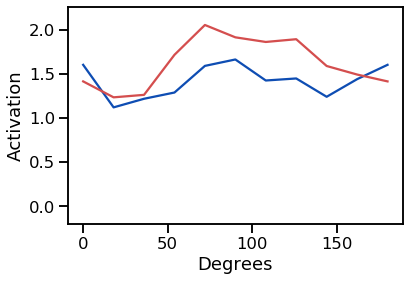

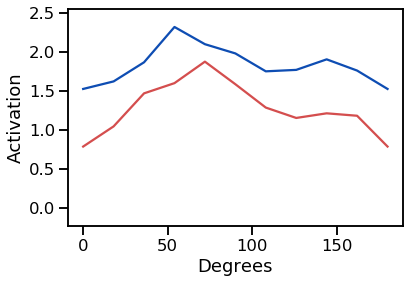

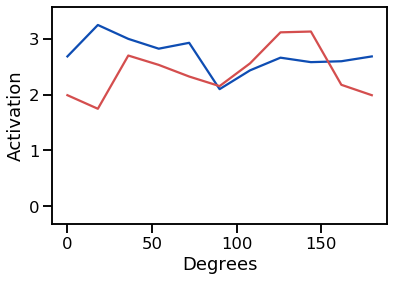

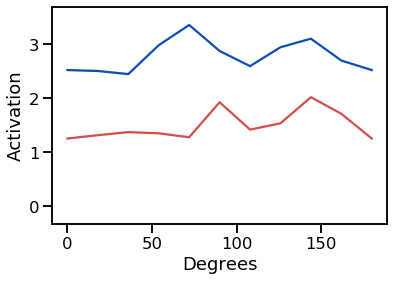

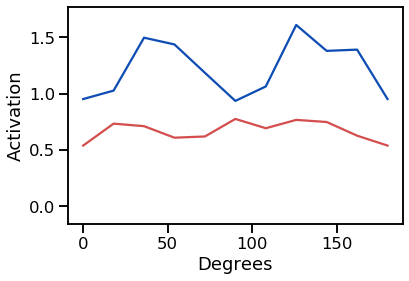

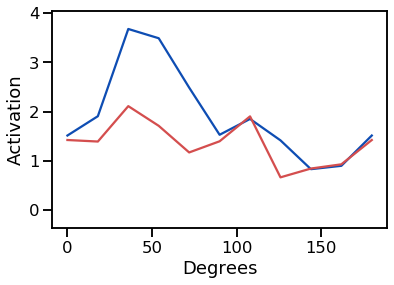

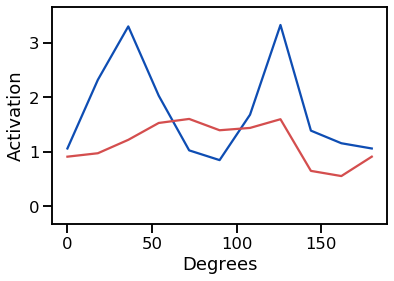

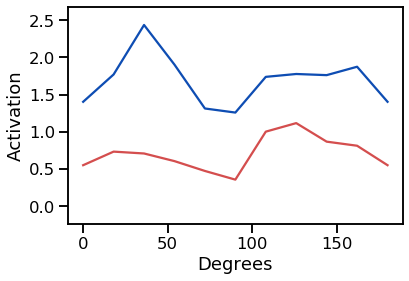

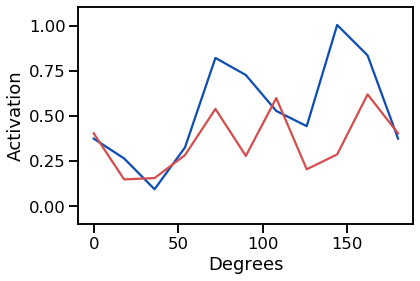

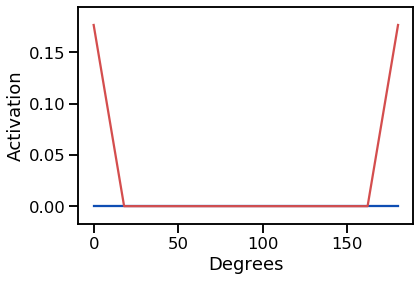

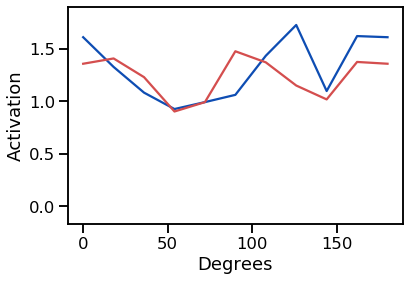

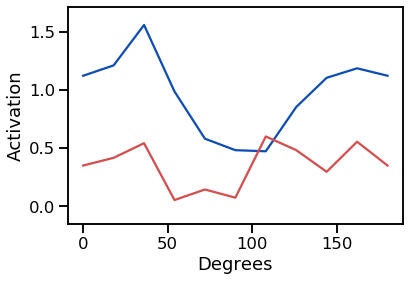

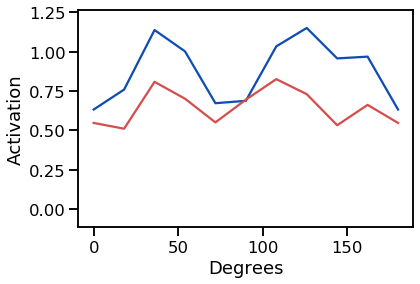

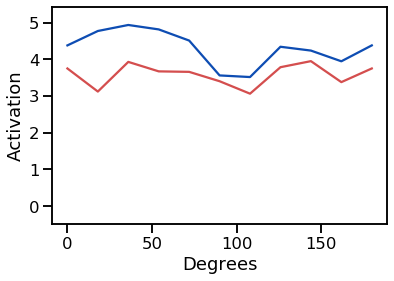

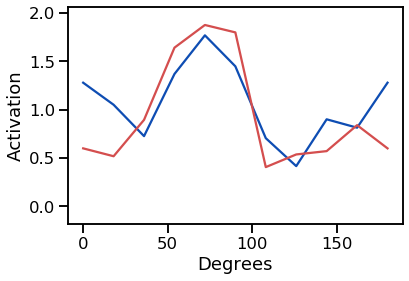

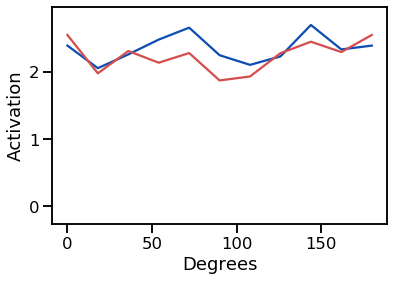

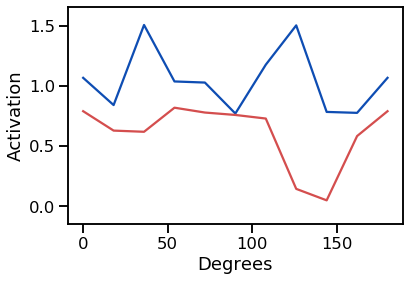

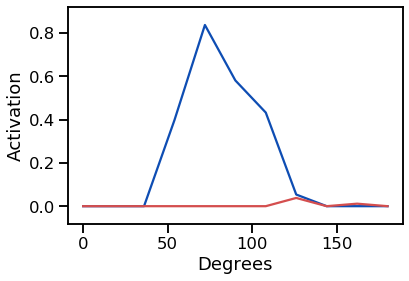

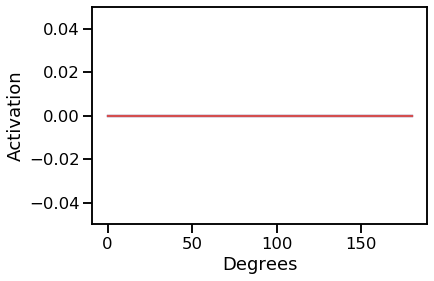

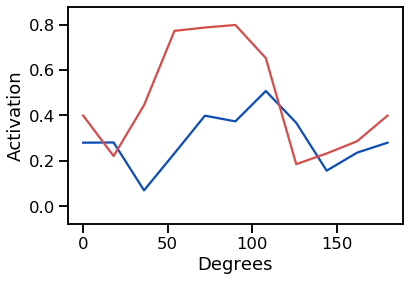

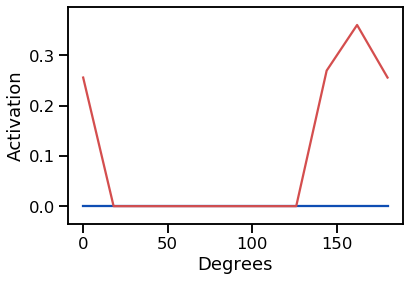

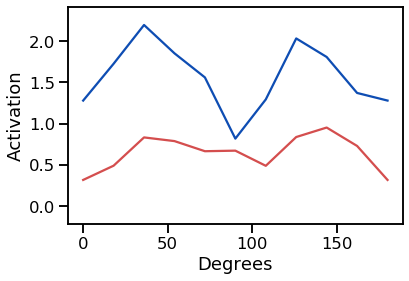

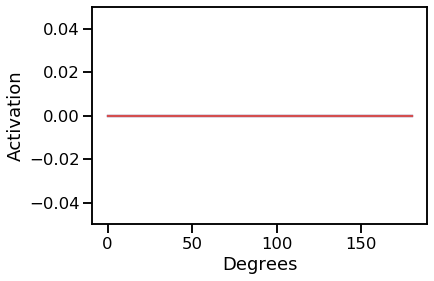

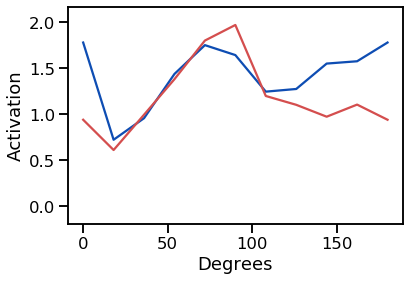

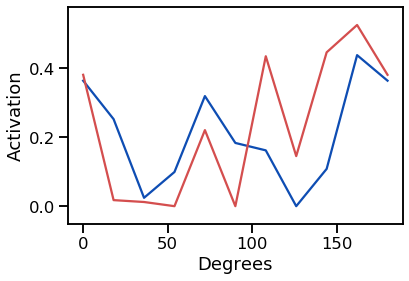

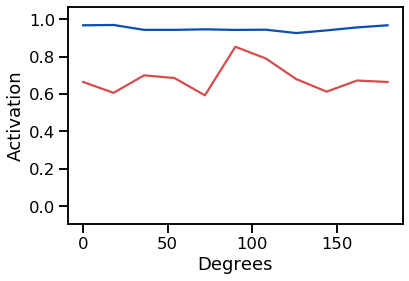

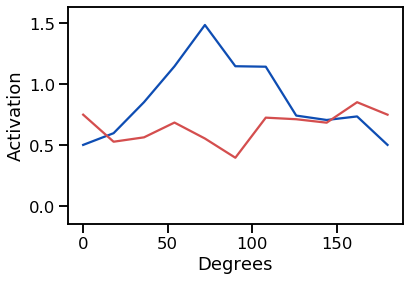

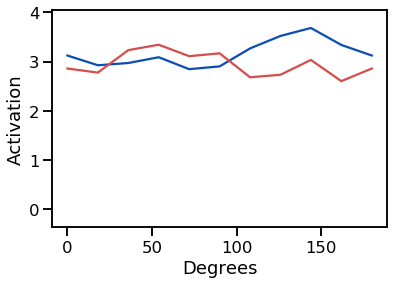

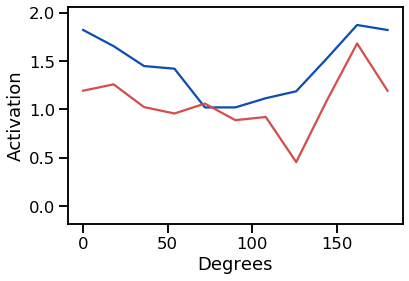

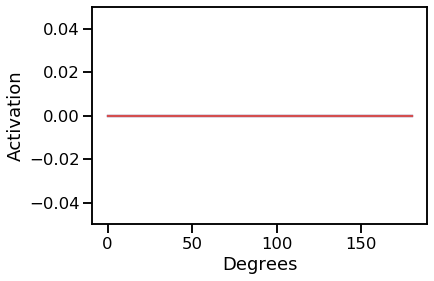

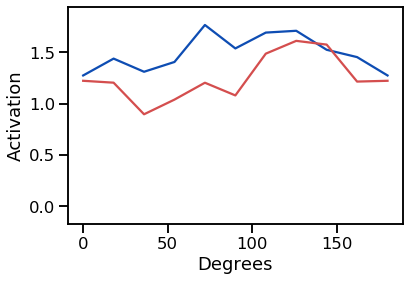

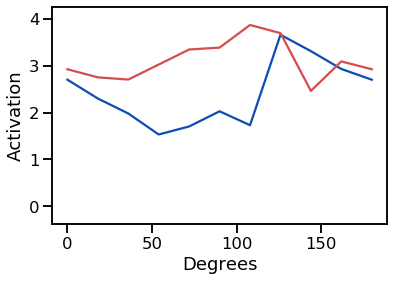

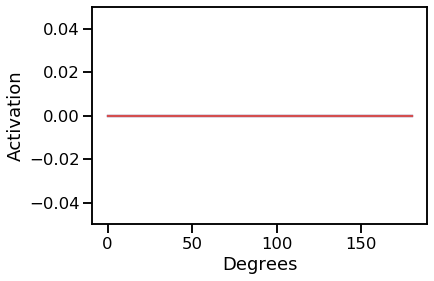

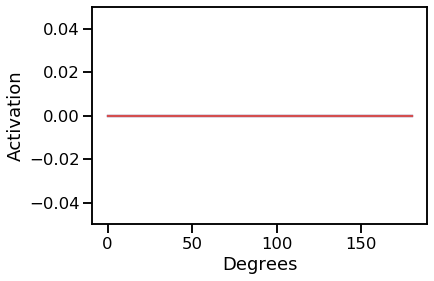

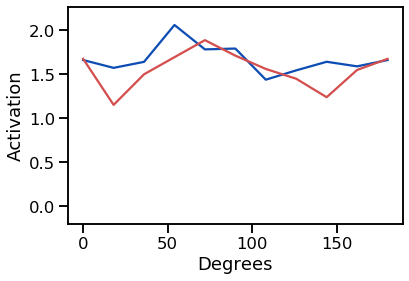

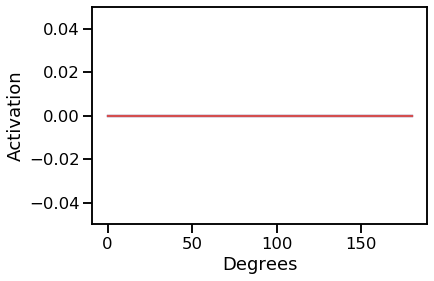

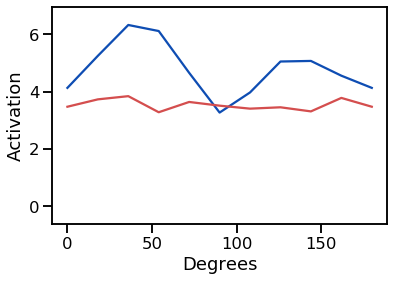

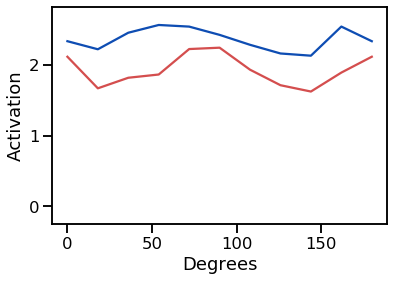

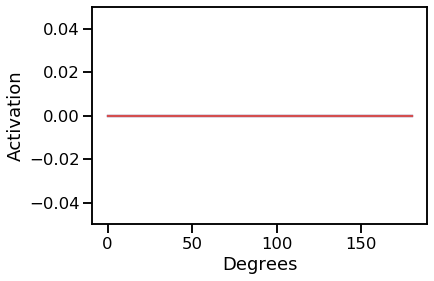

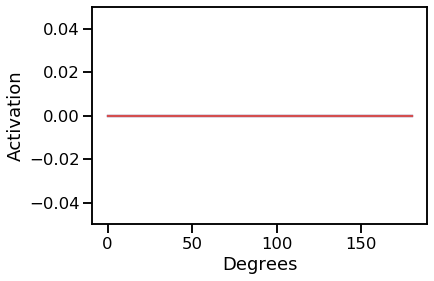

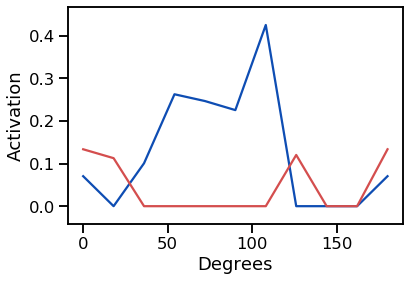

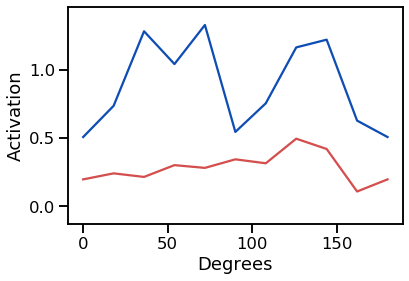

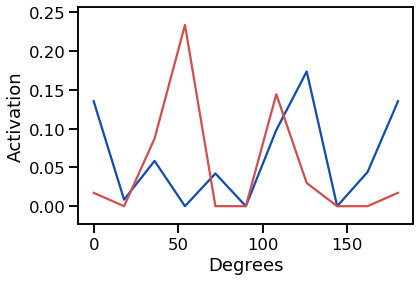

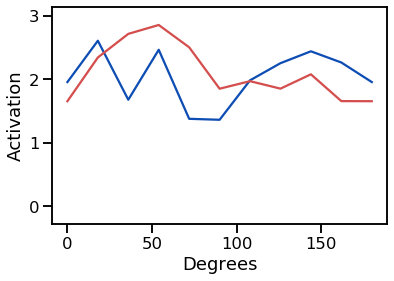

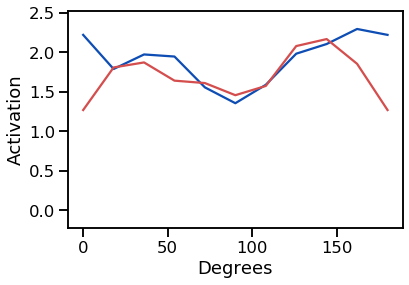

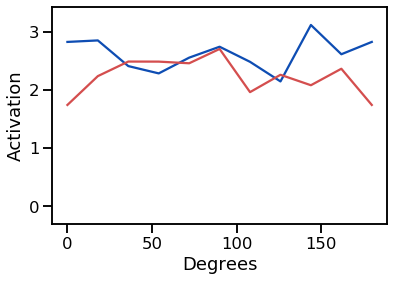

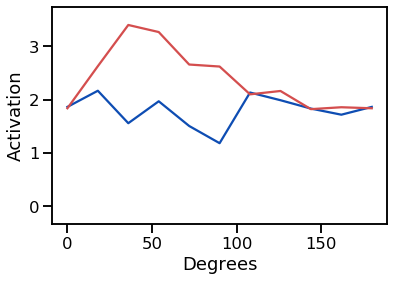

In [13]:
plot_curves(attended_activations, not_attended_activations, degrange)

In [99]:
np.stack(attended_activations[layer], 3).shape

(20, 6, 6, 11)